Fate analysis stratified by source, looking at a single $w_s$ at a time

In [137]:
from stompy.model.fish_ptm import ptm_tools
import matplotlib.pyplot as plt
import glob, os
import pandas as pd
from stompy import utils
from stompy.spatial import wkb2shp
from matplotlib import cm
import numpy as np
import xarray as xr
import re

from matplotlib.colors import LogNorm
from stompy.model.suntans import sun_driver
%matplotlib notebook

In [2]:
small=1e-4

def map_bilog(x):
    return np.sign(x)*np.log10(np.abs(x).clip(small,np.inf)/small)
def unmap_bilog(y):
    return np.sign(y)*small*10**np.abs(y)

from matplotlib.ticker import ScalarFormatter
sf=ScalarFormatter()
sf._usetex=True
def mapped_label(y):
    if y==0.0:
        #s="\pm " + sf.format_data(small)
        #s="0"
        s="passive"
    else:
        s=sf.format_data(unmap_bilog(y))
    s="$"+s+"$"
    if y>0:
        s=" "+s
    return s


In [57]:
source_names={
"src000":"EBDA",
"src001":"EBMUD",
"src002":"SFPUC",
"NAPA":"Napa River",
"cccsd":"CCCSD",
"SCLARAVCc":"Guadalupe River",
"SCLARAVW5":"Calabazas Creek",
"COYOTE":"Coyote Creek",
"SJRiver":"San Joaquin River",
"SacRiver":"Sacramento River",
"ddsd":"DDSD",
"fs":"Fairfield-Suisun",
"lg":"Las Gallinas",
"UALAMEDA":"Alameda Flood Control",
"palo_alto":"Palo Alto",
"petaluma":"Petaluma River",
"san_jose":"San Jose",
"sonoma_valley":"Sonoma Valley",
"sunnyvale":"Sunnyvale"
}

In [110]:
#run_set=dict(ptm_bin_files=glob.glob('all_sources/ebmud_all_w/*_bin.out'),
#             name='ebda_all_w')

# Newer run, with fewer classes, but longer time, and includes
# napa.
#run_set=dict(ptm_bin_files=glob.glob('all_sources/ebda_most_w_dec/src000_*_bin.out'),
#             name='ebda_most_w')

#run_set=dict(ptm_bin_files=glob.glob('all_sources/ebda_most_w_dec/NAPA_*_bin.out'),
#             name='napa_most_w')

#run_set=dict(ptm_bin_files=glob.glob('all_sources/all_source_select_w/*_none_bin.out'),
#             label_by='source',
#             name='all_source_passive')
# filter out lg -- it's bad.
#run_set['ptm_bin_files']=[f for f in run_set['ptm_bin_files'] if 'lg_' not in f]


run_set=dict(ptm_bin_files=glob.glob('all_sources/all_source_select_w/*_up2000_bin.out'),
             label_by='source',
             name='all_source_float')
# filter out lg -- it's bad.
#run_set['ptm_bin_files']=[f for f in run_set['ptm_bin_files'] if 'lg_' not in f]

In [111]:
run_set['ptm_bin_files']

['all_sources/all_source_select_w/san_jose_up2000_bin.out',
 'all_sources/all_source_select_w/cccsd_up2000_bin.out',
 'all_sources/all_source_select_w/petaluma_up2000_bin.out',
 'all_sources/all_source_select_w/ddsd_up2000_bin.out',
 'all_sources/all_source_select_w/SJRiver_up2000_bin.out',
 'all_sources/all_source_select_w/sonoma_valley_up2000_bin.out',
 'all_sources/all_source_select_w/UALAMEDA_up2000_bin.out',
 'all_sources/all_source_select_w/palo_alto_up2000_bin.out',
 'all_sources/all_source_select_w/lg_up2000_bin.out',
 'all_sources/all_source_select_w/sunnyvale_up2000_bin.out',
 'all_sources/all_source_select_w/fs_up2000_bin.out',
 'all_sources/all_source_select_w/src000_up2000_bin.out',
 'all_sources/all_source_select_w/src002_up2000_bin.out',
 'all_sources/all_source_select_w/COYOTE_up2000_bin.out',
 'all_sources/all_source_select_w/NAPA_up2000_bin.out',
 'all_sources/all_source_select_w/SCLARAVCc_up2000_bin.out',
 'all_sources/all_source_select_w/SacRiver_up2000_bin.out',
 '

In [112]:
ptms=pd.DataFrame()
ptms['bin_file']=run_set['ptm_bin_files']

label_by=run_set.get('label_by','w_s')

# Get settling velocities just from the filename
ptm_bin_w_s=[]
ptm_bin_src=[]
ptms['w_s']=0
ptms['src']=""

for i,row in ptms.iterrows():
    fn=os.path.basename(row['bin_file'])
    g=re.match("(.*)_(down|up|none)([0-9]*)_bin.out",fn)
    if g.group(2)=='none':
        w_s=0.0
    else:
        w_s=float(g.group(3))/1e6
        if g.group(1)=='up': w_s*=-1
    
    ptms.at[i,'w_s']=w_s
    ptms.at[i,'src']=g.group(1)    

if label_by=='w_s':  
    ptms=ptms.sort_values('w_s',ascending=False)
    leg_title="w$_s$ (m s$^{-1}$)"
elif label_by=='source':
    ptms=ptms.sort_values('src')
    leg_title='Pathway'
ptms=ptms.reset_index()


In [113]:
ptm_bins=[ptm_tools.PtmBin(bf) for bf in ptms['bin_file'].values]
ptms['bin']=ptm_bins

In [114]:
labels=[]
for i,row in ptms.iterrows():
    if label_by=='w_s':
        labels.append( mapped_label(map_bilog(row.w_s)))
    else:
        labels.append( source_names.get(row['src'],row['src']) )
ptms['label']=labels

In [115]:
last_timesteps=[b.count_timesteps() for b in ptms['bin']]
tstep=min(last_timesteps)-1
tstep

1533

In [35]:
model=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_009-20171201/")
grid=model.grid

INFO:DFlowModel:Will read cell depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [116]:
# Define in bay vs. out of bay
regions=wkb2shp.shp2geom("../suntans/grid-merged/poly_features.shp")
ocean_poly=regions[ regions['name']=='ocean_region']['geom'][0]

from matplotlib.path import Path
ocean_path=Path(vertices=np.array(ocean_poly.exterior),closed=True)

In [133]:
# Now look at how long particles have been in the system.
# each particle is given an age from release, whether
# it has exited, and its w_s.
# then we look at how exit fraction for each w_s corresponds
# to age
# process a single group at a time
def escape_dataset(pb,stride=24):
    ages=[] # list of arrays
    in_oceans=[] # lists of arrays

    # indexed by particle id.
    rel_times=np.zeros(0,'<M8[s]')

    xy0=None
    for tstep in range(0,pb.count_timesteps(),stride):
        t,parts=pb.read_timestep(tstep)
        if xy0 is None and len(parts):
            xy0=parts['x'].mean(axis=0)
        t=utils.to_dt64(t)
        if len(parts)==0:
            print("0", end='')
            continue
        print(".", end='')
            
        in_ocean=ocean_path.contains_points(parts['x'][:,:2])
        # Update particle ages for new particles.
        # only accurate to within the stride of this loop.
        N_new_parts=parts['id'].max() - len(rel_times)
        if N_new_parts>0:
            new_rel_times=np.ones(N_new_parts,rel_times.dtype)
            new_rel_times[:]=t
            rel_times=utils.array_concatenate([rel_times,new_rel_times])

        ages.append( (t-rel_times[parts['id']-1])/np.timedelta64(1,'s') / 86400. )
        in_oceans.append(in_ocean)
    print()
    if len(ages)==0:
        return None
    # put this into a DataFrame just to get the nice grouping code
    df_exit=pd.DataFrame()
    df_exit['age']=np.concatenate(ages)
    df_exit['in_ocean']=np.concatenate(in_oceans)
    # convert to a summary of count in_ocean by age
    exit_summary=(df_exit.groupby(['age','in_ocean']).size()
                   .unstack(fill_value=0).stack() )
    exit_summary=exit_summary.to_frame()
    exit_summary.rename({0:'count'},axis=1,inplace=True)
    # then get back to dataset land for better dimension handling
    ds=xr.Dataset.from_dataframe(exit_summary)
    ds['nparts']=ds['count'].sum(dim='in_ocean')
    if True not in ds['in_ocean']:
        # in some cases no particles from a group ever make it out.
        ds['ocean_pct']=ds.nparts.dims,0*ds.nparts
    else:
        ds['ocean_pct']=100. * ds['count'].sel(in_ocean=True) / ds['nparts']
        
    if xy0 is not None:
        ds['x0']=(),xy0[0]
        ds['y0']=(),xy0[1]
    return ds

In [134]:
age_thresh=0.95

escape_datasets=[]
ds_subs=[]

ptms['escape']=None
ptms['escape_sel']=None
ptms['exit_frac']=0.0
ptms['x0']=np.nan
ptms['y0']=np.nan
        
for i,row in ptms.iterrows():
    print(row['bin_file'])
    ds=escape_dataset(row['bin'])
    if ds is not None:
        ptms.at[i,'escape']=ds
        age_sel=ds.age.values<age_thresh*ds.age.values.max()
        ds_sub=ds.isel(age=age_sel)
        ptms.at[i,'escape_sel']=ds_sub
        ptms.at[i,'exit_frac']=ds_sub.ocean_pct.values.max()
        ptms.at[i,'x0']=ds_sub.x0.item()
        ptms.at[i,'y0']=ds_sub.y0.item()
            

all_sources/all_source_select_w/COYOTE_up2000_bin.out
................................................................
all_sources/all_source_select_w/NAPA_up2000_bin.out
................................................................
all_sources/all_source_select_w/SCLARAVCc_up2000_bin.out
................................................................
all_sources/all_source_select_w/SJRiver_up2000_bin.out
................................................................
all_sources/all_source_select_w/SacRiver_up2000_bin.out
................................................................
all_sources/all_source_select_w/UALAMEDA_up2000_bin.out
................................................................
all_sources/all_source_select_w/cccsd_up2000_bin.out
................................................................
all_sources/all_source_select_w/ddsd_up2000_bin.out
................................................................
all_sources/all_source_select_w/fs_up2000_bin

<IPython.core.display.Javascript object>


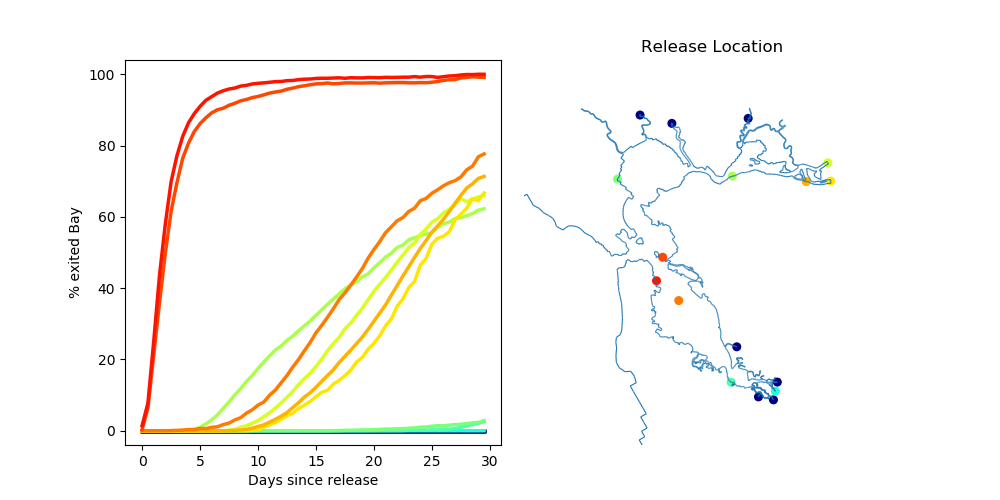

In [148]:
# Ages above this fraction of the max are not plotted
# since typically not enough particles to get a good
# distibution.

show_legend=False
show_map=True

if show_map:
    fig,(ax,ax_map)=plt.subplots(1,2,figsize=(10,5))
else:
    fig=plt.figure(figsize=(7,4.5))
    ax=fig.add_subplot(1,1,1)

        
# drop no-particle sources
ptm_sel=ptms[ ~ptms.escape_sel.isnull() ]

if 1: # Order by exit speed
    exit_fracs=[ds.ocean_pct.values.max() for ds in ptm_sel['escape_sel']]
    order=np.argsort(exit_fracs)
    ptm_sel=ptm_sel.iloc[order,:]
    ptm_sel=ptm_sel.reset_index()

colors=[]

for i,row in ptm_sel.iterrows():
    ds=row['escape_sel']
    col=cm.jet(float(i)/len(ptms))
    lbl=row['label']
    lw=2.5
    
    if label_by=='w_s' and w_s==0.0:
        col='k'

    if label_by=='source' and ds.ocean_pct.values.max()==0.0:
        col=cm.jet(0.0)
    
    ax.plot(ds.age,
            ds.ocean_pct,
            color=col,lw=lw,label=lbl)
    colors.append(col)
        
if show_legend:
    ax.legend(handles=ax.lines[::-1],title=leg_title,
             loc='upper left',bbox_to_anchor=[1.01,1.01])
    fig.subplots_adjust(right=0.78)
    
if show_map:
    grid.plot_boundary(ax=ax_map)
    ax_map.xaxis.set_visible(0)
    ax_map.yaxis.set_visible(0)
    plt.setp(ax_map.spines.values(),visible=0)
    ax_map.scatter( ptm_sel.x0, ptm_sel.y0, 30, colors)
    # ptm_sel.exit_frac)
    ax_map.axis( (530241., 614867., 4126991., 4247225.) )
    
ax.set_ylabel("% exited Bay")
ax.set_xlabel("Days since release")
# ax.axis(xmin=0,xmax=28)
ax.axis(ymin=-4,ymax=104)

fn='escape_time2'
if show_map:
    fn+='_map'
fn+="_%s.png"%run_set['name']

fig.subplots_adjust(wspace=0.06)
ax_map.set_title('Release Location')

fig.savefig(fn,dpi=150)


Text(0.5, 1.0, 'Release Location')

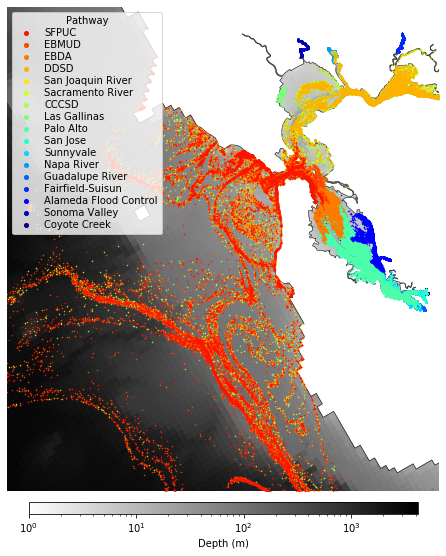

In [120]:
fig=plt.figure(figsize=(6,8))
ax=fig.add_subplot(1,1,1)
zoom=(475100., 575922., 4081601., 4240793.)

ccoll=grid.plot_cells(values=-grid.cells['depth'].clip(-np.inf,-1),
                      cmap=cm.gray_r,
                      lw=0.8,
                      norm=LogNorm())
ccoll.set_edgecolor('face')

for i,row in ptm_sel.iterrows():
    col=cm.jet(float(i)/len(ptms))
    t,parts=row['bin'].read_timestep(tstep)
    ax.plot(parts['x'][:,0],parts['x'][:,1],'.',color=col,ms=1,
            label=row['label'])
    
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
cax=fig.add_axes([0.05,0.07,0.9,0.02])
plt.colorbar(ccoll,cax=cax,label='Depth (m)',orientation='horizontal')

if label_by=='w_s': # Flip to feel like depth
    cax_zoom=cax.axis()
    cax.axis(ymin=cax_zoom[3],ymax=cax_zoom[2])
    
plt.setp( ax.spines.values(), visible=0)
grid.plot_boundary(color='k',lw=0.5,ax=ax)
ax.axis(zoom)
fig.subplots_adjust(left=0.00,top=0.95,bottom=0.11,right=1.)
handles=ax.lines[::-1]
labels=[h.get_label() for h in handles]

ax.legend(labels=labels,handles=ax.lines[::-1],
          loc='upper left',bbox_to_anchor=[0.0,1],
          title=leg_title,
          markerscale=8,labelspacing=0.2)
fig.savefig('%s-end_map2.png'%run_set['name'],dpi=100)

In [33]:
# Generate a dataframe showing percent in/out of the Bay
# at the end of the run (or by time step tstep)
recs=[]

for i,pb in enumerate(ptm_bins):
    t,parts=pb.read_timestep(tstep)

    in_ocean=ocean_path.contains_points(parts['x'][:,:2])
    rec=dict(w_s=ptm_bin_w_s[i],
             nparts=len(parts['x']),
             in_ocean=in_ocean.sum(),
             in_bay=(~in_ocean).sum())
    recs.append(rec)

df=pd.DataFrame(recs)
df['% Ocean']=(100*df.in_ocean / df.nparts).round(1)
df['% Bay']  =(100*df.in_bay   / df.nparts).round(1)
df['# Particles']=df.nparts

df=df.set_index('w_s')

df_summary=df.loc[:, ['# Particles', '% Bay','% Ocean']]
df_summary.to_excel('%s-escape-summary.xlsx'%run_set['name'])